# Light Gradient Boosting Machine (LightGBM)

Light Gradient Boosting Machine (LightGBM) is a distributed gradient boosting (Gradient Boosting Decision Tree, GBDT) framework based on decision tree algorithm. In the data environment of large training samples and high-dimensional features, compared with GBDT, LightGBM has faster training speed and efficiency, lower memory usage, better accuracy, supports parallel learning and can process large-scale data.

In [34]:
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import joblib
from sklearn import preprocessing

In [35]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
DATA_DIR = './data/'
IMG_DIR = './img/'
PROCESSED_DATA_DIR = './processed_data/'
TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'test.csv'
PROCESSED_TRAIN_FILE = PROCESSED_DATA_DIR + 'processed_train.csv'
PROCESSED_TEST_FILE = PROCESSED_DATA_DIR + 'processed_test.csv'
AUX_DATA_DIR = DATA_DIR + 'auxiliary-data/'
SUBZONE_FILE = AUX_DATA_DIR + 'sg-subzones.csv'

## 1. Train

In [37]:
df = pd.read_csv(PROCESSED_TRAIN_FILE)

In [38]:
# df = df.drop(columns = ['pa_ang_mo_kio', 'pa_bedok', 'pa_bishan', 
#                         'pa_boon_lay','pa_bukit_batok','pa_bukit_merah',
#                         'pa_bukit_panjang','pa_bukit_timah','pa_central_water_catchment',
#                         'pa_changi','pa_changi_bay','pa_choa_chu_kang','pa_clementi',
#                         'pa_downtown_core','pa_geylang','pa_hougang','pa_jurong_east',
#                         'pa_jurong_west','pa_kallang','pa_lim_chu_kang','pa_mandai',
#                         'pa_marina_south','pa_marine_parade','pa_museum',
#                         'pa_newton','pa_north-eastern_islands','pa_novena',
#                         'pa_orchard','pa_outram','pa_pasir_ris','pa_paya_lebar',
#                         'pa_pioneer','pa_punggol','pa_queenstown','pa_river_valley',
#                         'pa_rochor','pa_seletar','pa_sembawang','pa_sengkang',
#                         'pa_serangoon','pa_simpang','pa_singapore_river',
#                         'pa_southern_islands','pa_straits_view','pa_sungei_kadut',
#                         'pa_tampines','pa_tanglin','pa_tengah','pa_toa_payoh',
#                         'pa_tuas','pa_western_islands','pa_western_water_catchment',
#                         'pa_woodlands','pa_yishun'])

In [39]:
X, y = df.drop(columns = ['price']), df['price']
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

### 1.1. Histogram algorithm

LightGBM uses a histogram-based algorithm to discretize continuous eigenvalues into K integers, construct a histogram with a width of K, traverse the training data, and count the cumulative statistics of each discrete value in the histogram. When selecting the split points of a feature, it is only necessary to traverse the discrete values of the sorted histogram. 

The use of the histogram algorithm reduces the computational cost of the algorithm. The pre-sort adopted by XGBoost needs to traverse each eigenvalue and calculate the split gain, while the histogram algorithm only needs to calculate K times, which improves the efficiency of finding split points; reduces the memory of the algorithm Consumption, it is not necessary to store the pre-sorted results, only the discretized values of the features need to be saved. 

Because the decision tree itself is a weak learner, the use of the histogram to discretize the eigenvalues can have a regularization effect, and the discretized split points can improve the generalization ability of the algorithm.

### 1.2. Leaf-wise algorithm

Most decision tree learning algorithms use a level-wise strategy for tree generation. The difference is that LightGBM adopts a more efficient leaf-wise strategy.

The strategy finds a leaf node with the largest splitting gain from all the leaf nodes of the current decision tree each time, and then splits it, and so on. Such a mechanism reduces the split calculation of leaf nodes with lower gains and reduces a lot of unnecessary overhead.

Compared with the level-wise strategy, leaf-wise can reduce the error and get better accuracy with the same number of splits. The disadvantage of the leaf-wise algorithm is that it may generate deeper decision trees. Therefore, LightGBM adds parameters that limit the maximum depth to leaf-wise, which prevents overfitting while ensuring the efficiency of the algorithm.



In [40]:
estimator = LGBMRegressor(objective='regression', learning_rate=0.1, metric='rmse', 
                          min_child_weight=0.001, colsample_bytree=0.9)

- boosting: default=gbdt, type=enum, options=gbdt, rf, dart, goss, alias=boost, boosting_type

gbdt, traditional gradient boosted decision tree

rf, Random Forest

dart, Dropouts meet Multiple Additive Regression Trees

goss, Gradient-based One-Side Sampling

- objective, default=regression, type=enum, options=regression, regression_l1, huber, fair, poisson, quantile, quantile_l2, binary, multiclass, multiclassova, xentropy, xentlambda, lambdarank, alias=objective, app , application

regression application

regression_l2, L2 loss, alias=regression, mean_squared_error, mse

regression_l1, L1 loss, alias=mean_absolute_error, mae

huber, huber loss

fair, fair loss

poisson, Poisson regression

quantile, Quantile regression

quantile_l2, similar to quantile, but uses L2 loss

- learning_rate, default=0.1, type=double, alias=shrinkage_rate

In dart, shrinkage rate also affects the normalized weight of dropped trees

- metric, default={l2 for regression}, {binary_logloss for binary classification}, {ndcg for lambdarank}, type=multi-enum, options=l1, l2, ndcg, auc, binary_logloss, binary_error …

l1, absolute loss, alias=mean_absolute_error, mae

l2, square loss, alias=mean_squared_error, mse

l2_root, root square loss, alias=root_mean_squared_error, rmse

quantile, Quantile regression

huber, huber loss

fair, fair loss

poisson, Poisson regression

ndcg, NDCG

map, MAP

auc, AUC

binary_logloss, log loss

In [41]:
param_grid = {
    'max_depth':[4, 5, 6],
    'num_leaves':[25, 30],
    'n_estimators':[110, 120],
    'min_child_samples': [5, 10],
    'subsample': [0.9, 1.0]
}

- max_depth, default=-1, type=int

Limit the maximum depth of the tree model. This prevents overfitting when #data is small. The tree can still grow leaf-wise.

&lt; 0 means no limit.

- num_leaves, default=31, type=int, alias=num_leaf

number of leaves on a tree

- min_data_in_leaf, default=20, type=int, alias=min_data_per_leaf , min_data, min_child_samples

The minimum amount of data on a leaf. 

Can be used to deal with overfitting.

- bagging_fraction, default=1.0, type=double, 0.0 &lt; bagging_fraction &lt; 1.0, alias=sub_row, subsample

Similar to feature_fraction, but it will randomly select parts of the data without resampling

Can be used to speed up training

Can be used to deal with overfitting

Note: In order to enable bagging, bagging_freq should be set to a non-zero value

In [42]:
gbm = GridSearchCV(estimator, param_grid, verbose=3, cv=5, scoring='neg_mean_squared_error')
gbm.fit(X_scaled, y)

joblib.dump(gbm, 'gbm_model.pkl')
print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=4, min_child_samples=5, n_estimators=110, num_leaves=25, subsample=0.9;, score=-3102407525506.156 total time=   0.2s
[CV 2/5] END max_depth=4, min_child_samples=5, n_estimators=110, num_leaves=25, subsample=0.9;, score=-7814737400176.667 total time=   0.3s
[CV 3/5] END max_depth=4, min_child_samples=5, n_estimators=110, num_leaves=25, subsample=0.9;, score=-1876953351860.470 total time=   0.2s
[CV 4/5] END max_depth=4, min_child_samples=5, n_estimators=110, num_leaves=25, subsample=0.9;, score=-2143516078016.121 total time=   0.3s
[CV 5/5] END max_depth=4, min_child_samples=5, n_estimators=110, num_leaves=25, subsample=0.9;, score=-2346348411050.105 total time=   0.2s
[CV 1/5] END max_depth=4, min_child_samples=5, n_estimators=110, num_leaves=25, subsample=1.0;, score=-3102407525506.156 total time=   0.2s
[CV 2/5] END max_depth=4, min_child_samples=5, n_estimators=110, num_leaves=25, subsample=1.0;, sc

[CV 5/5] END max_depth=4, min_child_samples=10, n_estimators=110, num_leaves=30, subsample=1.0;, score=-2572180177529.387 total time=   0.2s
[CV 1/5] END max_depth=4, min_child_samples=10, n_estimators=120, num_leaves=25, subsample=0.9;, score=-2966838730856.302 total time=   0.2s
[CV 2/5] END max_depth=4, min_child_samples=10, n_estimators=120, num_leaves=25, subsample=0.9;, score=-7293400596390.129 total time=   0.2s
[CV 3/5] END max_depth=4, min_child_samples=10, n_estimators=120, num_leaves=25, subsample=0.9;, score=-2311533336488.236 total time=   0.2s
[CV 4/5] END max_depth=4, min_child_samples=10, n_estimators=120, num_leaves=25, subsample=0.9;, score=-2227127962803.027 total time=   0.2s
[CV 5/5] END max_depth=4, min_child_samples=10, n_estimators=120, num_leaves=25, subsample=0.9;, score=-2526710624036.543 total time=   0.2s
[CV 1/5] END max_depth=4, min_child_samples=10, n_estimators=120, num_leaves=25, subsample=1.0;, score=-2966838730856.302 total time=   0.2s
[CV 2/5] END 

[CV 4/5] END max_depth=5, min_child_samples=5, n_estimators=120, num_leaves=30, subsample=1.0;, score=-1825254246491.779 total time=   0.3s
[CV 5/5] END max_depth=5, min_child_samples=5, n_estimators=120, num_leaves=30, subsample=1.0;, score=-2503028395873.782 total time=   0.3s
[CV 1/5] END max_depth=5, min_child_samples=10, n_estimators=110, num_leaves=25, subsample=0.9;, score=-2686972485671.548 total time=   0.2s
[CV 2/5] END max_depth=5, min_child_samples=10, n_estimators=110, num_leaves=25, subsample=0.9;, score=-6466717104492.852 total time=   0.2s
[CV 3/5] END max_depth=5, min_child_samples=10, n_estimators=110, num_leaves=25, subsample=0.9;, score=-2021533390284.194 total time=   0.2s
[CV 4/5] END max_depth=5, min_child_samples=10, n_estimators=110, num_leaves=25, subsample=0.9;, score=-2120783853313.719 total time=   0.2s
[CV 5/5] END max_depth=5, min_child_samples=10, n_estimators=110, num_leaves=25, subsample=0.9;, score=-2731114791804.317 total time=   0.2s
[CV 1/5] END ma

[CV 3/5] END max_depth=6, min_child_samples=5, n_estimators=110, num_leaves=30, subsample=1.0;, score=-1636177263320.304 total time=   0.3s
[CV 4/5] END max_depth=6, min_child_samples=5, n_estimators=110, num_leaves=30, subsample=1.0;, score=-2106557845740.303 total time=   0.4s
[CV 5/5] END max_depth=6, min_child_samples=5, n_estimators=110, num_leaves=30, subsample=1.0;, score=-2230815792049.533 total time=   0.3s
[CV 1/5] END max_depth=6, min_child_samples=5, n_estimators=120, num_leaves=25, subsample=0.9;, score=-2472444094109.018 total time=   0.3s
[CV 2/5] END max_depth=6, min_child_samples=5, n_estimators=120, num_leaves=25, subsample=0.9;, score=-7610967343092.176 total time=   0.4s
[CV 3/5] END max_depth=6, min_child_samples=5, n_estimators=120, num_leaves=25, subsample=0.9;, score=-1473902577311.195 total time=   0.5s
[CV 4/5] END max_depth=6, min_child_samples=5, n_estimators=120, num_leaves=25, subsample=0.9;, score=-2032749875628.707 total time=   0.5s
[CV 5/5] END max_dep

[CV 2/5] END max_depth=6, min_child_samples=10, n_estimators=120, num_leaves=30, subsample=1.0;, score=-6512951718169.465 total time=   0.3s
[CV 3/5] END max_depth=6, min_child_samples=10, n_estimators=120, num_leaves=30, subsample=1.0;, score=-1865183070077.187 total time=   0.3s
[CV 4/5] END max_depth=6, min_child_samples=10, n_estimators=120, num_leaves=30, subsample=1.0;, score=-2035800928059.603 total time=   0.4s
[CV 5/5] END max_depth=6, min_child_samples=10, n_estimators=120, num_leaves=30, subsample=1.0;, score=-2831573753428.544 total time=   0.3s
Best parameters found by grid search are: {'max_depth': 6, 'min_child_samples': 5, 'n_estimators': 120, 'num_leaves': 25, 'subsample': 0.9}


- estimator

Choose the classifier to use, and pass in parameters other than the ones that need to be determined optimal. Each classifier requires a scoring parameter, or score method.

- param_grid

The value of the parameter to be optimized, the value is a dictionary or a list

- verbose=0, scoring=None

verbose: log verbosity, int: verbosity, 0: do not output the training process, 1: occasionally output, > 1: output for each sub-model.

In [43]:
y_pred = gbm.predict(X_scaled)

print('The rmse of prediction is:', mean_squared_error(y, y_pred) ** 0.5)

The rmse of prediction is: 775276.8032167498


## 2. Test

In [44]:
df = pd.read_csv(PROCESSED_TEST_FILE)

In [45]:
# df = df.drop(columns = ['pa_ang_mo_kio', 'pa_bedok', 'pa_bishan', 
#                         'pa_boon_lay','pa_bukit_batok','pa_bukit_merah',
#                         'pa_bukit_panjang','pa_bukit_timah','pa_central_water_catchment',
#                         'pa_changi','pa_changi_bay','pa_choa_chu_kang','pa_clementi',
#                         'pa_downtown_core','pa_geylang','pa_hougang','pa_jurong_east',
#                         'pa_jurong_west','pa_kallang','pa_lim_chu_kang','pa_mandai',
#                         'pa_marina_south','pa_marine_parade','pa_museum',
#                         'pa_newton','pa_north-eastern_islands','pa_novena',
#                         'pa_orchard','pa_outram','pa_pasir_ris','pa_paya_lebar',
#                         'pa_pioneer','pa_punggol','pa_queenstown','pa_river_valley',
#                         'pa_rochor','pa_seletar','pa_sembawang','pa_sengkang',
#                         'pa_serangoon','pa_simpang','pa_singapore_river',
#                         'pa_southern_islands','pa_straits_view','pa_sungei_kadut',
#                         'pa_tampines','pa_tanglin','pa_tengah','pa_toa_payoh',
#                         'pa_tuas','pa_western_islands','pa_western_water_catchment',
#                         'pa_woodlands','pa_yishun'])

In [46]:
gbm = joblib.load('gbm_model.pkl')

In [47]:
output = pd.read_csv('./example-submission.csv')
output["Predicted"] = gbm.predict(df)
output.to_csv('gbm_submission.csv', index=False)

## 3. Analysis

<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

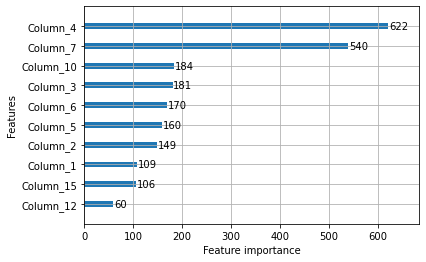

In [51]:
gbm = joblib.load('gbm_model.pkl')
plot_importance(gbm.best_estimator_, title=None, height=0.3, max_num_features = 10)

I list the top ten most important features.

The most important feature is size_sqft, followed by subzone_property_type_encoding, which is reasonable in common sense.

The third one is nearest_mrt_km, which is the distance between the property and MRT.

The following four features, num_baths, num_beds, lng, lat, the importance is almost same.

Then, the feature is built_year, num_sm_3km, num_ps_1km_to_2km